<a href="https://colab.research.google.com/github/kovzanok/dls-final-task/blob/main/Final_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Установка зависимостей

In [1]:
!pip install insightface onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060443 sha256=1de1fb9827bb267b8f401d2b5c805d6c229ebbe9d4a0746630e51f900d3d2243
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [2]:
from torch import nn
from insightface.app import FaceAnalysis
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
import cv2
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

import random
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Подготовка данных

##Архив изображений

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba/

In [6]:
def get_filenames_os(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

In [7]:
filenames = get_filenames_os('/content/celeba/img_align_celeba')

In [8]:
idx = random.sample(range(len(filenames)), 100)

In [9]:
random_files = [ filenames[i] for i in idx ]

##Разметка "имя изображения  - id"

In [10]:
df = pd.read_csv('/content/drive/MyDrive/identity_CelebA.txt', delim_whitespace=True, header=None,index_col=0)

<ipython-input-10-2280069971>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('/content/drive/MyDrive/identity_CelebA.txt', delim_whitespace=True, header=None,index_col=0)


In [11]:
df.index.name = 'image_name'
df.rename(columns={1:'id'},inplace=True)

In [12]:
filtered_df = df.loc[random_files]
le = LabelEncoder()
filtered_df['encoded_id'] = le.fit_transform(filtered_df['id'])

#Пайплайн

##Детекция лиц

In [13]:
# Инициализируем модель
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=-1, det_size=(640, 640))  # ctx_id=0 — GPU, -1 — CPU

# Путь к папке с 100 изображениями
image_folder = "/content/celeba/img_align_celeba"
image_paths = [os.path.join(image_folder, fname) for fname in random_files]

# Результаты
all_faces = []

for path in tqdm(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img)  # список найденных лиц
    all_faces.append({
        'image_path': path,
        'faces': faces  # каждый face — это dict с bbox, landmarks и т.д.
    })

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:07<00:00, 38863.74KB/s]
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


  0%|          | 0/100 [00:00<?, ?it/s]

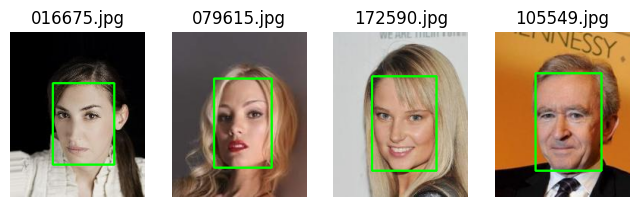

In [14]:
fig = plt.figure(figsize=(8, 8))

for i, idx in enumerate(random.sample(range(len(all_faces)),4)):
    img = cv2.imread(all_faces[idx]['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    for face in all_faces[idx]['faces']:
        x1, y1, x2, y2 = map(int, face.bbox)
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        fig.add_subplot(1, 4, i+1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(os.path.basename(all_faces[idx]['image_path']))

plt.show()

In [15]:
save_dir = "/content/cropped_faces"
os.makedirs(save_dir, exist_ok=True)

for entry in all_faces:
    image_path = entry['image_path']
    filename = os.path.basename(image_path)  # например, '000001.jpg'

    img = cv2.imread(image_path)

    # Берём только первое лицо (если нужно все — можно изменить)
    face = entry['faces'][0]
    x1, y1, x2, y2 = map(int, face.bbox)

    # Защита от выхода за границы
    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    face_crop = img[y1:y2, x1:x2]

    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, face_crop)


##Определение ключевых точек

###HourglassNet

Написанный за нас ResidualBlock

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

Рекурсивный HourglassBlock, позволяющий задать его глубину

In [17]:
class HourglassBlock(nn.Module):
    def __init__(self, channels, depth):
        super().__init__()
        self.depth = depth

        self.res = ResidualBlock(channels, channels)

        if depth > 1:
            self.next = HourglassBlock(channels, depth - 1)
        else:
            self.center = ResidualBlock(channels, channels)


        self.downsample = nn.MaxPool2d(kernel_size=2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        skip = self.res(x)
        x = self.downsample(skip)

        if self.depth > 1:
            x = self.next(x)
        else:
            x = self.center(x)

        x = self.upsample(x)
        return x + skip

HourglassNet, состоящая из 3 HourglassBlock(каждый глубиной 4), 3 голов и специальных merge слоев(тут мне ChatGPT помог, обосновав их наличие тем, что так лучше обучается модель, чем обычный skip connection).

In [18]:
class HourglassNet(nn.Module):
    def __init__(self, channels=128, depth=4):
        super().__init__()
        self.initial_conv = nn.Conv2d(3, channels, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

        self.hg1 = HourglassBlock(channels,depth)
        self.hg2 = HourglassBlock(channels,depth)
        self.hg3 = HourglassBlock(channels,depth)

        self.merge1 = nn.Conv2d(5, channels, kernel_size=1)
        self.merge2 = nn.Conv2d(5, channels, kernel_size=1)

        self.head1 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head2 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head3 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )

        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, channels, 1)
        self.conv3 = nn.Conv2d(channels, channels, 1)


    def forward(self, x):
        x = self.initial_conv(x)
        x = self.relu(self.bn(x))
        skip1 = self.hg1(x)
        res1 = self.head1(self.conv1(skip1))
        inter1 = skip1 + self.merge1(res1)
        skip2 = self.hg2(inter1)
        res2 = self.head2(self.conv2(skip2))
        inter2 = skip2 + self.merge2(res2)
        x = self.hg3(inter2)
        res3 = self.head3(self.conv3(x))
        return [res1, res2, res3]



In [19]:
model = HourglassNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth', weights_only=True, map_location=device))

<All keys matched successfully>

###Датасет

In [20]:
class NamedCelebADataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = img_names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

###Функции

In [21]:
def align_face(image, keypoints, output_size=(112, 112)):
    template = np.array([
        [30.2946, 51.6963],  # левый глаз
        [65.5318, 51.5014],  # правый глаз
        [48.0252, 71.7366],  # нос
        [33.5493, 92.3655],  # левый рот
        [62.7299, 92.2041]   # правый рот
    ], dtype=np.float32)

    if output_size[0] == 112:
        pass
    else:
        template[:, 0] += (output_size[0] - 112) / 2

    keypoints = np.array(keypoints, dtype=np.float32)
    M, _ = cv2.estimateAffinePartial2D(keypoints, template, method=cv2.LMEDS)
    aligned_face = cv2.warpAffine(image, M, output_size, borderValue=0.0)

    return aligned_face


In [22]:
def heatmap_to_coords(hm):
    coords = []
    for i in range(hm.shape[0]):
        y, x = torch.nonzero(hm[i] == hm[i].max(), as_tuple=True)
        if len(x) > 0 and len(y) > 0:
            coords.append((x[0].item(), y[0].item()))
        else:
            coords.append((0, 0))
    return coords

###Выравнивание

In [25]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

named_dataset = NamedCelebADataset(
    img_dir='/content/cropped_faces',
    transform=transform,
    img_names = filtered_df.index.to_list()
)

loader = DataLoader(named_dataset)

save_dir = "/content/aligned_faces"
os.makedirs(save_dir, exist_ok=True)

@torch.no_grad()
def transform_images(loader, model):
    total_res = []

    fig, axes = plt.subplots(1, 4, figsize=(5 * 4, 5))

    for i, (image, name) in enumerate(tqdm(loader, leave=False)):
        model.eval()
        image = image.to(device)
        outputs = model(image)
        pred_heatmaps = outputs[-1]
        img = image[0]
        img_vis = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        pred = pred_heatmaps[0]
        pred_coords = heatmap_to_coords(pred)

        img_pil = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        img_np = np.array(img_pil)

        ax = axes[i] if 4 > 1 else axes
        ax.imshow(img_vis)
        ax.set_title(f"Sample {i+1}")
        ax.scatter([x for x, y in pred_coords], [y for x, y in pred_coords], c='red', marker='x', label='Pred', s=20)
        ax.axis('off')

        # aligned_image = torch.tensor(align_face(img_np,pred_coords)).permute(2,0,1)
        # aligned_image = aligned_image.float() / 255.0

        # file_path = os.path.join(save_dir, name[0])
        # vutils.save_image(aligned_image,file_path)



  0%|          | 0/100 [00:00<?, ?it/s]

IndexError: index 4 is out of bounds for axis 0 with size 4

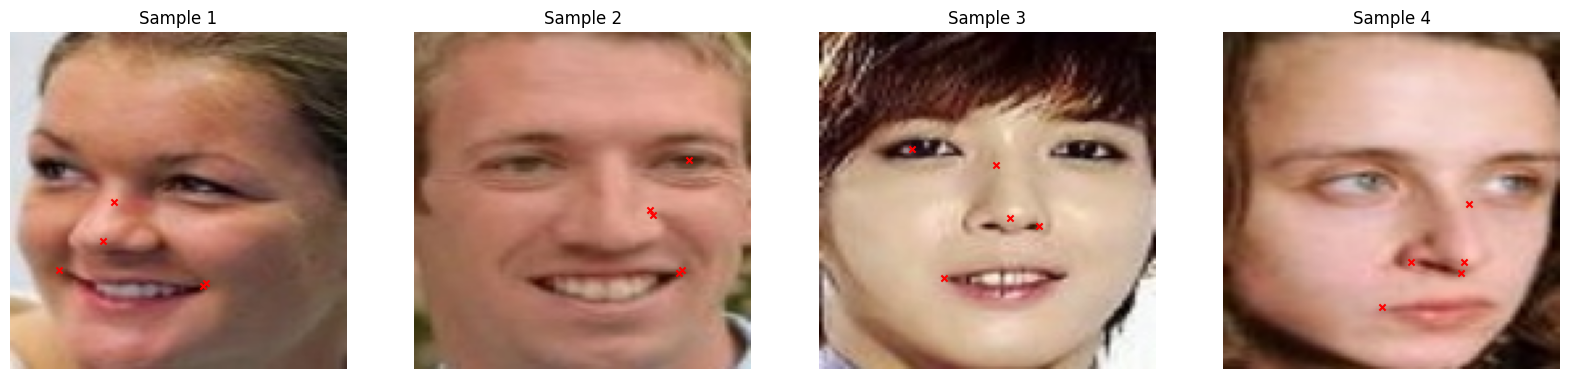

In [26]:
transform_images(loader, model)